import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [59]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
import pandas
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
import pandas as pd
import numpy as np
from haversine import haversine, Unit
from functions import *
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.color_palette("rocket_r", as_cmap=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Player info
player_gdf = gpd.read_file("data/player_gdf.geojson")[['fullName', 'birthCity', 'city_province', 'geometry']]

In [3]:
# shape of North America to plot data 
us_can_gdf = gpd.read_file("data/full_us_can_geometry.geojson", driver='GeoJSON')

## Data Engineering

In [4]:
# flipping the lat and longitude for the player_gdf
player_gdf['Lat'] = player_gdf['geometry'].x
player_gdf['Lng'] = player_gdf['geometry'].y
player_gdf['geometry'] = [Point(coord.y, coord.x) for coord in player_gdf['geometry']]

In [5]:
# just player coords
player_coords = player_gdf[['fullName', 'Lat', 'Lng']]

# Clustergram

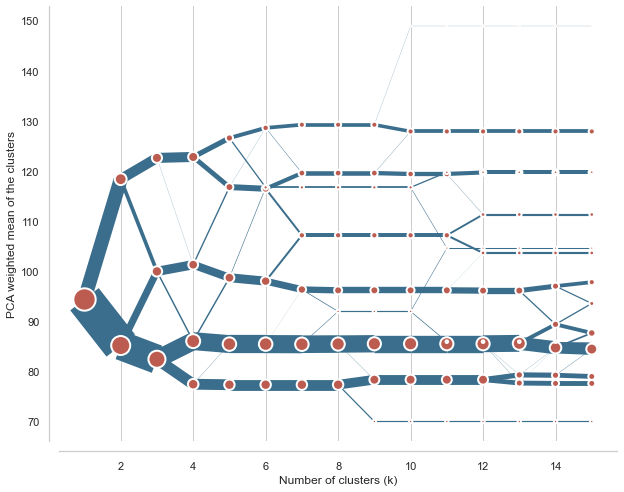

In [6]:
data = player_coords.drop(columns=['fullName'])
cgram = fit_plot_clustergram(data, end_range=16)

## Analyzing the optimal number of clusters

In [7]:
statistical_tests_values, statistical_tests_rec_cluster = evaluate_num_of_clusters(cgram)
statistical_tests_values

array([[1.20937601],
       [0.62297262],
       [0.00845454],
       [0.        ],
       [0.26854397],
       [0.41314414],
       [0.57427331],
       [0.6116543 ],
       [0.71232097],
       [0.932808  ],
       [1.04461046],
       [1.18999627],
       [1.26592117],
       [1.48184195]])

In [8]:
statistical_tests_rec_cluster

15

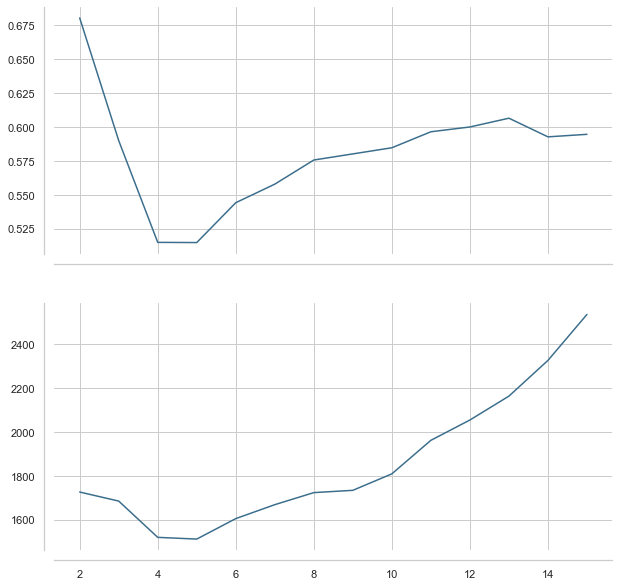

In [9]:
visualize_num_of_clusters(cgram)

We could cluster this in very small, or very large number of clusters. Based on the clustergram graph, I think **2 clusters makes the most sense**. At 3 and >9 clusters, most of the new divisions are very narrowly different from the previous iteration.

# Cluster the data

## Kmeans
This clusters ALL of the data into two categories. It is our baseline model, so to speak.

In [10]:
# adjusting the data to be an array
X = np.array(player_coords[['Lat', 'Lng']])
# applying Kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# adding labels to player_gdf
player_gdf['player_cluster'] = kmeans.labels_
player_gdf_w_centroids = add_kmeans_centroids_to_gdf(player_gdf, kmeans)

Text(0.5, 1.0, "Optimal Clustering of NHL Players' Birthplaces into 2 Clusters (with centroids)")

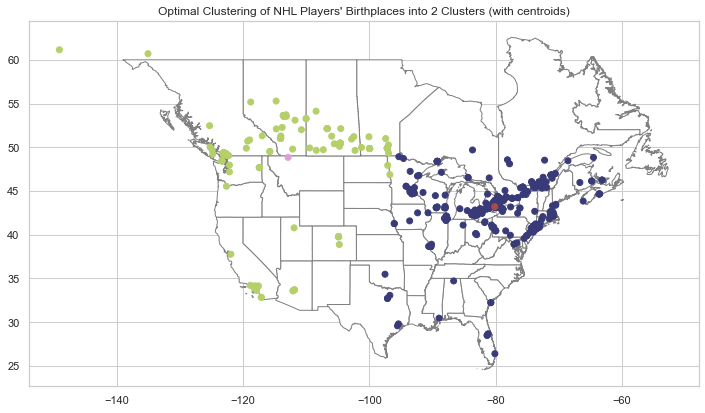

In [11]:
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
plot_clusters(us_can_gdf, player_gdf_w_centroids, "player_cluster")
plt.title("Optimal Clustering of NHL Players' Birthplaces into 2 Clusters (with centroids)")
# plt.savefig("pictures/player_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

## DBSCAN

I'm using this clustering algorithm in order to find more local clusters that will leave out outliers and make this more coherent (not many people would group florida with quebec city players but that's what the kmeans algorithm did)

### Finding clusters by using algorithm multiple times with different parameters

The goal here is to find **consistent** clusters that emerge over multiple parameter choices. To do this, I will find the cities that are found in multiple different parameters of the DBSCAN model. We will consider these places together as clusters.

In [12]:
# where I will store my data
noisey_data_df = pd.DataFrame()
noisey_data_df = player_gdf[['fullName', 'city_province']]

In [13]:
# find clustered data for a set of parameters, add to df
for eps in range(4, 14, 2):
    new_eps = eps/10
    for min_sample in range(5, 20, 5):
        noisey_data = run_cluster_determine_noise(new_eps, min_sample, X)
        col_name = f"Test{new_eps}_{min_sample}"
        noisey_data_df[col_name] = noisey_data

In [14]:
# Adding sum of cluster to df
cluster_sum = noisey_data_df.sum(axis=1)
noisey_data_df['cluster_sum'] = cluster_sum

In [15]:
birthplace_cluster_df = pd.DataFrame(noisey_data_df.groupby('city_province').cluster_sum.mean())
# 183 of the birthplaces are in 2/3 of the clusters created by DBSCAN
cluster_num_cutoff = round((15/3)*2) # a player can be in at most 15 clusters
in_most_cluster_df = birthplace_cluster_df[birthplace_cluster_df['cluster_sum'] >= cluster_num_cutoff]

In [16]:
# retrieve coordinates for each player passing cutoff
player_gdf_dbscan_cluster = player_gdf[player_gdf['city_province'].isin(in_most_cluster_df.index)]

In [17]:
player_gdf_dbscan_cluster

,fullName,birthCity,city_province,geometry,Lat,Lng,player_cluster
0,Nathan Bastian,Kitchener,"Kitchener,ON",POINT (-80.47280 43.41860),43.4186,-80.4728,0
1,Tyce Thompson,Calgary,"Calgary,AB",POINT (-114.06670 51.05000),51.0500,-114.0667,1
2,Travis Zajac,Winnipeg,"Winnipeg,MB",POINT (-97.14640 49.88440),49.8844,-97.1464,1
3,P.K. Subban,Toronto,"Toronto,ON",POINT (-79.37330 43.74170),43.7417,-79.3733,0
4,Scott Wedgewood,Brampton,"Brampton,ON",POINT (-79.76670 43.68330),43.6833,-79.7667,0
...,...,...,...,...,...,...,...
577,Connor Hellebuyck,Commerce,"Commerce,MI",POINT (-83.48780 42.57940),42.5794,-83.4878,0
578,Kyle Connor,Shelby Township,"Shelby Township,MI",POINT (-83.03310 42.67080),42.6708,-83.0331,0
579,Christian Dvorak,Palos,"Palos,IL",POINT (-87.82640 41.69920),41.6992,-87.8264,0
580,Conor Garland,Scituate,"Scituate,MA",POINT (-70.72640 42.19580),42.1958,-70.7264,0


# Analyzing the clusters 

## KMeans

How many players are in each cluster?

In [18]:
# clusters: 0 = east coast, 1 = west coast
# 2-3x more players in cluster 0 (east coast) than other clusters
player_gdf.player_cluster.value_counts()

0    420
1    162
Name: player_cluster, dtype: int64

## DBSCAN

How many players are in each cluster?

In [19]:
# this shows which cities are well represented
player_gdf_dbscan_cluster.city_province.value_counts()[0:5]

Toronto,ON     27
Calgary,AB     16
London,ON      12
Edmonton,AB    10
Winnipeg,MB    10
Name: city_province, dtype: int64

### Determining number of clusters for new grouping of data

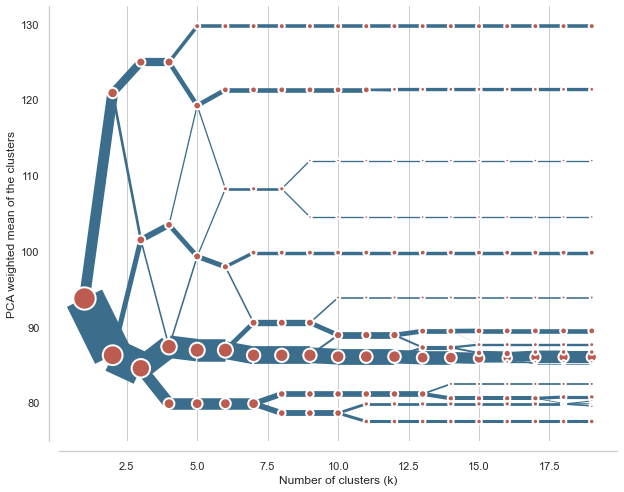

In [20]:
# adjusting the data to be an array
dbscan_coords = player_coords[player_coords['fullName'].isin(player_gdf_dbscan_cluster.fullName)][['Lat', 'Lng']]
cgram_post_dbscan = fit_plot_clustergram(dbscan_coords, end_range=20)

In [21]:
evaluate_num_of_clusters(cgram_post_dbscan)

(array([[0.72629411],
        [0.26836722],
        [0.01234503],
        [0.21341299],
        [0.38193666],
        [0.35739554],
        [0.60926274],
        [0.81787297],
        [0.94363522],
        [1.16747186],
        [1.30471337],
        [1.21798401],
        [1.47600665],
        [1.1611279 ],
        [1.40782702],
        [1.68926456],
        [1.66974009],
        [1.60043292]]),
 17)

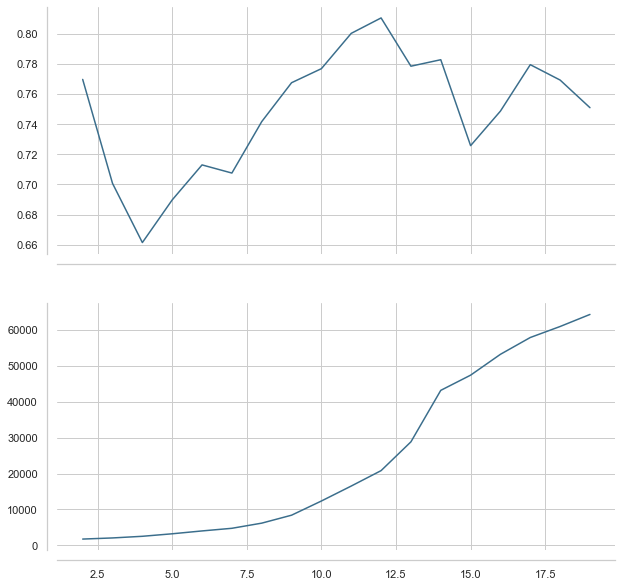

In [22]:
visualize_num_of_clusters(cgram_post_dbscan)

The more clusters, the better the model fits. However, I think that is slightly too specific for our taste. The last meaningful split in the clustergram graph occurs at 12, so we will use **12 clusters** when grouping our modified data.

### Grouping players into cities again (using kmeans, 12 clusters)

In [23]:
# applying Kmeans
kmeans_dbscan = KMeans(n_clusters=12, random_state=0).fit(dbscan_coords)
# adding labels to player_gdf
player_gdf_dbscan_cluster['player_cluster_dbscan'] = kmeans_dbscan.labels_
# dbscan_coords['player_cluster_dbscan'] = kmeans_dbscan.labels_

Text(0.5, 1.0, "12 Identified Clusters from NHL Players' Birthplaces")

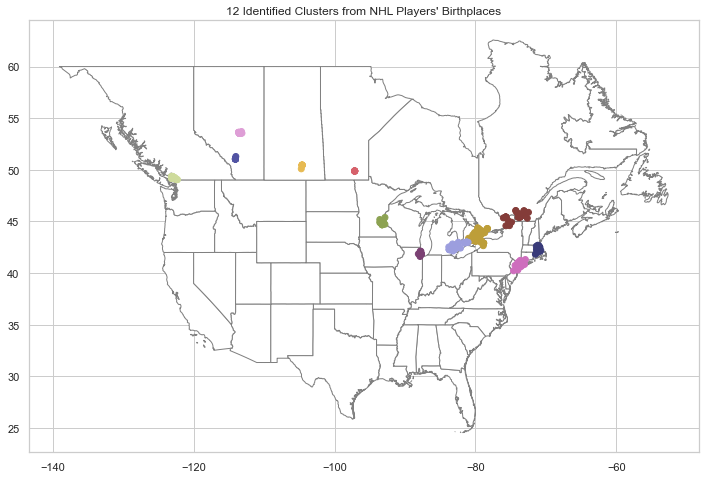

In [24]:
# interesting that ottawa and montreal are together 
plot_clusters(us_can_gdf, player_gdf_dbscan_cluster, "player_cluster_dbscan")
plt.title("12 Identified Clusters from NHL Players' Birthplaces")
# plt.savefig("pictures/player_clusters.png", bbox_inches='tight', pad_inches=0.2)

#### Assigning names to the clusters

In [25]:
# convert number to string
## add string to dict and find name of city
## use replace to get names in player_gdf_dbscan_cluster

In [26]:
city_names = ['Vancouver,BC', 'Boston,MA', 'Detroit,MI', 'Minneapolis,MN', 'Toronto,ON', 'Regina,SK', 
              'Montreal,QC', 'Winnipeg,MB', 'Chicago,IL', 'Brooklyn,NY', 'Edmonton,AB', 'Calgary,AB']
player_gdf_dbscan_cluster = assign_clusters_names(player_gdf_dbscan_cluster, city_names)

In [27]:
cluster_count_df = pd.DataFrame(player_gdf_dbscan_cluster.groupby('Cluster_name').count()['Lat']).reset_index()
cluster_count_df.columns = ['Cluster_name','Num_of_players']

In [28]:
# from https://stackoverflow.com/questions/52973106/sorting-dataframe-using-pandas-keeping-columns-intact
cluster_count_df_sorted = cluster_count_df.sort_values(by='Num_of_players', kind='mergesort', ascending=False) 

Text(0.5, 1.0, 'The Number of Current NHL Players in Regional Clusters within the U.S. and Canada')

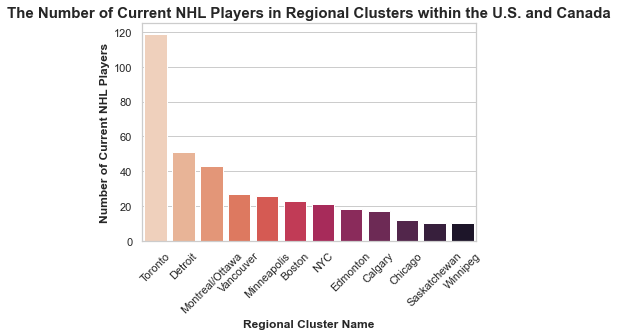

In [29]:
ax = sns.barplot(x='Cluster_name', y='Num_of_players', data=cluster_count_df_sorted, palette='rocket_r')
ax.set_xticklabels(cluster_count_df_sorted['Cluster_name'], rotation=45)
ax.set_xlabel('Regional Cluster Name', fontweight='bold')
ax.set_ylabel('Number of Current NHL Players', fontweight='bold')
ax.set_title("The Number of Current NHL Players in Regional Clusters within the U.S. and Canada",
            fontweight='bold', fontsize='15')
# plt.savefig("pictures/barplot_of_player_clusters.png", bbox_inches='tight', pad_inches=0.2)

In [34]:
# how many players does this account for? What proportion of all NA NHL players?
total_num_NHL_players = 839
pct_players_in_clusters = cluster_count_df['Num_of_players'].sum() / player_gdf.shape[0]
print(f"The 12 clusters represent {round(pct_players_in_clusters*100)}% of all North American NHL players")
pct_total_players_in_clusters = cluster_count_df['Num_of_players'].sum() / total_num_NHL_players
print(f"The 12 clusters represent {round(pct_total_players_in_clusters*100)}% of ALL NHL players")

The 12 clusters represent 65.0% of all North American NHL players
The 12 clusters represent 45.0% of ALL NHL players


In [35]:
toronto_count = cluster_count_df[cluster_count_df['Cluster_name'] == 'Toronto']['Num_of_players'].values[0]
detroit_count = cluster_count_df[cluster_count_df['Cluster_name'] == 'Detroit']['Num_of_players'].values[0]
num_players_in_det_buf_tor = toronto_count + detroit_count

In [36]:
pct_na_players_in_det_buf_tor = round((num_players_in_det_buf_tor / player_gdf.shape[0]) * 100)
pct_total_players_in_det_buf_tor = round((num_players_in_det_buf_tor / total_num_NHL_players) * 100)
print(f"The Detroit/Toronto/Buffalo cluster represents {pct_na_players_in_det_buf_tor}% of all North American NHL players")
print(f"The Detroit/Toronto/Buffalo cluster represents {pct_total_players_in_det_buf_tor}% of ALL NHL players")

The Detroit/Toronto/Buffalo cluster represents 29.0% of all North American NHL players
The Detroit/Toronto/Buffalo cluster represents 20.0% of ALL NHL players


### Finding Player Density for Each Cluster

In [245]:
# I can't figure out what units this area is in (I believe it's degrees or something like that)
## this analysis is flawed since the cluster's are arbitrary (Calgary has all players in "Calgary")
### I would need the shapes of those cities in order to have a true number of players per area
cluster_shape_gdf = make_points_to_shape(gdf=player_gdf_dbscan_cluster)
# making number of players
cluster_shape_gdf['Num_of_players'] = cluster_shape_gdf['Cluster_name']
cluster_name_count = {x:y for x,y in 
                      list(zip(cluster_count_df['Cluster_name'],cluster_count_df['Num_of_players']))}
cluster_shape_gdf['Num_of_players'].replace(cluster_name_count, inplace=True)
cluster_shape_gdf['Player_density'] = cluster_shape_gdf['Num_of_players'] / cluster_shape_gdf['Area']
cluster_shape_gdf.sort_values(by='Player_density', ascending=False)

,Cluster_num,Cluster_name,geometry,Area,Num_of_players,Player_density
11,11,Edmonton,"POLYGON ((-113.30890 53.52330, -113.49030 53.5...",0.057548,18,312.783677
4,4,Vancouver,"POLYGON ((-122.31670 49.05000, -123.13330 49.1...",0.116969,27,230.830697
9,9,Chicago,"POLYGON ((-87.86190 41.60740, -88.10830 41.856...",0.122279,12,98.136446
3,3,Minneapolis,"POLYGON ((-93.25200 44.67740, -93.58860 44.916...",0.395610,26,65.721301
0,0,Boston,"POLYGON ((-71.49470 41.82670, -71.36780 42.599...",0.404627,23,56.842434
5,5,Toronto,"POLYGON ((-78.89470 42.65250, -80.74670 43.130...",2.819817,119,42.201318
2,2,Detroit,"POLYGON ((-83.19290 42.13940, -83.62050 42.243...",1.268407,51,40.207917
10,10,NYC,"POLYGON ((-74.59500 40.22380, -74.38450 40.740...",0.929985,21,22.581007
7,7,Montreal/Ottawa,"POLYGON ((-75.68330 44.58330, -76.04130 45.349...",3.279389,43,13.112199


<AxesSubplot:>

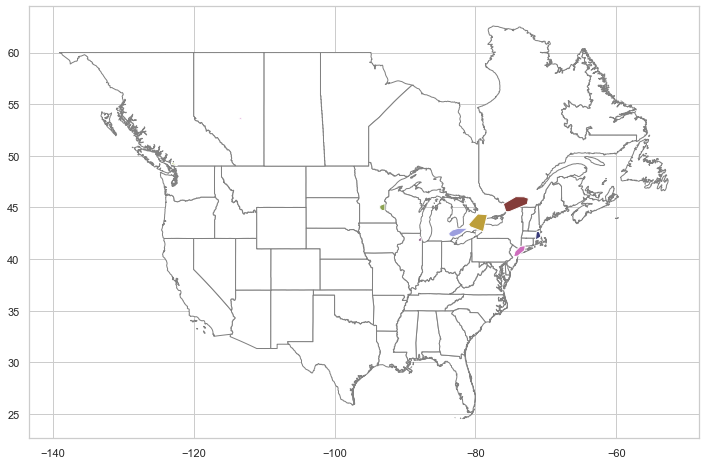

In [246]:
# as proof of the flaw in this analysis, one can barely see Vancouver or Edmonton in this map
plot_clusters(us_can_gdf, cluster_shape_gdf, "Cluster_num")